<a href="https://colab.research.google.com/github/farahbakhsh3/DeepAtariLearning/blob/master/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://www.dropbox.com/s/nxz7aqtmsiusezd/atari.rar
!apt install unrar
!unrar x -r atari.rar


--2018-10-31 16:37:34--  https://www.dropbox.com/s/nxz7aqtmsiusezd/atari.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nxz7aqtmsiusezd/atari.rar [following]
--2018-10-31 16:37:34--  https://www.dropbox.com/s/raw/nxz7aqtmsiusezd/atari.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd40324f67114a1fa775db9a606.dl.dropboxusercontent.com/cd/0/inline/AUavqqo7LahtYQN4PGnilYe1L23QnV_1yeCTC9XFHokxSlSGofXVZvKrnWSF3WqLdbTqyFcXDlqvV-RagedL07tHGT4cF6XZM9FHGsEQW6BlW0Nt3u_VBGOdrqDnqqED3TWKU9tpP661lbD_KGY-ldz07kRCjb8kElblspO-GCPOUPmz9byE40_x5AmiCs4jcLQ/file [following]
--2018-10-31 16:37:35--  https://ucd40324f67114a1fa775db9a606.dl.dropboxusercontent.com/cd/0/inline/AUavqqo7LahtYQN4PGnilYe1L23QnV_1yeCTC9XFHokxSlSGofXVZvKrnWSF

In [7]:
#!/usr/bin/env python
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, ConvLSTM2D, MaxPool2D
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from prepare import Sample, model_def
import matplotlib.pyplot as plt


def create_model_ConvLSTM2D(INPUT_SHAPE, OUT_SHAPE, dropout_prob=0.5):
    
    model = Sequential()

    model.add(ConvLSTM2D(32, kernel_size=(3, 3), padding='same', 
                            activation='relu', return_sequences=True, strides=(2, 2), 
                            input_shape=INPUT_SHAPE))
#     model.add(ConvLSTM2D(32, kernel_size=(3, 3), padding='same', 
#                             activation='relu', return_sequences=True, strides=(2, 2)))
    # model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_prob))

#     model.add(ConvLSTM2D(64, kernel_size=(3, 3), padding='same', 
#                             activation='relu', return_sequences=True))
    model.add(ConvLSTM2D(64, kernel_size=(3, 3), padding='same', 
                            activation='relu', return_sequences=True, strides=(2, 2)))
    # model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_prob))

#     model.add(ConvLSTM2D(128, kernel_size=(3, 3), padding='same',  
#                             activation='relu', return_sequences=True))
    model.add(ConvLSTM2D(128, kernel_size=(3, 3), padding='same', 
                            activation='relu', strides=(2, 2)))
    # model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_prob))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_prob))
    model.add(Dense(OUT_SHAPE, activation='softmax'))
    print(model.summary())

    return model


def create_model_Conv2D(INPUT_SHAPE, OUT_SHAPE, dropout_prob=0.5):

    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', 
                        activation='relu', input_shape=INPUT_SHAPE))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', 
                        activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_prob))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', 
                        activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', 
                        activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_prob))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', 
                        activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', 
                        activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_prob))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_prob))
    model.add(Dense(OUT_SHAPE, activation='softmax'))
    
    print(model.summary())
    
    return model

def series_generator(x_train, y_train, batch_size):
    index = _model_def.window_size
    while True:
        x = []
        y = []
        for i in range(batch_size):
            x.append(x_train[index - _model_def.window_size + i:index + i])
            y.append(y_train[index + i])
        
        x = np.array(x)
        y = np.array(y)
        index += batch_size
        if index >= x_train.shape[0]-batch_size:
            index = _model_def.window_size

        yield x, y

def convert_data_to_series(x_train, y_train, window_size):
    x_ = []
    for i in range(x_train.shape[0] - window_size):
        x_.append(x_train[i:i + window_size])
    x_train = np.array(x_)
    y_train = y_train[:x_train.shape[0]]

    return x_train, y_train


if __name__ == '__main__':

    _model_def = model_def()
    x_train = np.load("X.npy")
    y_train = np.load("Y.npy")
    y_train = to_categorical(y_train, num_classes=_model_def.OUT_SHAPE)

    epochs = 50
    batch_size = 128

    if _model_def.model == 'Conv2D':
        model = create_model_Conv2D(_model_def.INPUT_SHAPE, _model_def.OUT_SHAPE)
    elif _model_def.model == 'ConvLSTM2D':
        # x_train, y_train = convert_data_to_series(x_train, y_train, _model_def.window_size)
        model = create_model_ConvLSTM2D(_model_def.INPUT_SHAPE, _model_def.OUT_SHAPE)

    print('X_Train Shape: ', x_train.shape)
    print('Y_Train Shape: ', y_train.shape)
    print('---------------------------')
    
    if input('Train from zero: <z>  ,  Retrain by load prev weights: <r>  ::   ') == 'r':
        model.load_weights(_model_def.weights_file)
        print('Model weights loaded : ', _model_def.weights_file) 
    else:
        print('Train from zero.')
    print('---------------------------')
        
    chekpoint = ModelCheckpoint(filepath=_model_def.weights_file, 
                                monitor='loss', 
                                save_best_only=True, 
                                save_weights_only=True, 
                                verbose=True)
    
    model.compile(loss='categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])
    
    if _model_def.model == 'Conv2D':
        history = model.fit(x_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            shuffle=True, 
                            validation_split=0.05, 
                            callbacks=[chekpoint])

    elif _model_def.model == 'ConvLSTM2D':
        history = model.fit_generator(series_generator(x_train, y_train, batch_size), 
                            steps_per_epoch=x_train.shape[0]//batch_size-1,
                            epochs=epochs, 
                            workers=4,
                            verbose=1,
                            callbacks=[chekpoint])


    # model.save_weights(_model_def.weights_file)
    print('Best weights saved. ', _model_def.weights_file)
    print('---------------------------')


    history_dict = history.history
    loss_value = history_dict['acc']
    val_loss_value = history_dict['val_acc']
    epoches = range(1,len(loss_value) + 1)

    plt.plot(epoches, loss_value, 'bo', label='Traning accuracy')
    plt.plot(epoches, val_loss_value, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epoches')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

1: Boxing
2: RiverRaid
3: Enduro
4: SeaQuest
5: Tennis
6: SpaceInvaders
---------------------------
Game:  Riverraid ( Riverraid-v0 ) Selected.
---------------------------

1: Conv2D
2: ConvLSTM2D
---------------------------
Model:  ConvLSTM2D  Selected.
---------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_19 (ConvLSTM2D) (None, None, 53, 40, 32)  40448     
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 53, 40, 32)  0         
_________________________________________________________________
conv_lst_m2d_20 (ConvLSTM2D) (None, None, 27, 20, 64)  221440    
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 27, 20, 64)  0         
_________________________________________________________________
conv_lst_m2d_21 (ConvLSTM2D) (None, 14, 10, 128)       88

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


88/88 [==============================] - 143s 2s/step - loss: 2.3868 - acc: 0.2224
Epoch 3/50
88/88 [==============================] - 142s 2s/step - loss: 2.3753 - acc: 0.2346
Epoch 4/50
88/88 [==============================] - 142s 2s/step - loss: 2.3719 - acc: 0.2370
Epoch 5/50
88/88 [==============================] - 142s 2s/step - loss: 2.3651 - acc: 0.2410
Epoch 6/50
88/88 [==============================] - 142s 2s/step - loss: 2.3614 - acc: 0.2410
Epoch 7/50
88/88 [==============================] - 142s 2s/step - loss: 2.3580 - acc: 0.2462
Epoch 8/50
88/88 [==============================] - 142s 2s/step - loss: 2.3575 - acc: 0.2421
Epoch 9/50
88/88 [==============================] - 141s 2s/step - loss: 2.3486 - acc: 0.2369
Epoch 10/50
88/88 [==============================] - 141s 2s/step - loss: 2.3083 - acc: 0.2338
Epoch 11/50
88/88 [==============================] - 141s 2s/step - loss: 2.2735 - acc: 0.2346
Epoch 12/50
88/88 [==============================] - 141s 2s/step - l

KeyError: ignored

In [0]:
model.save_weights('ConvLSTM2D_Riverraid.h5')

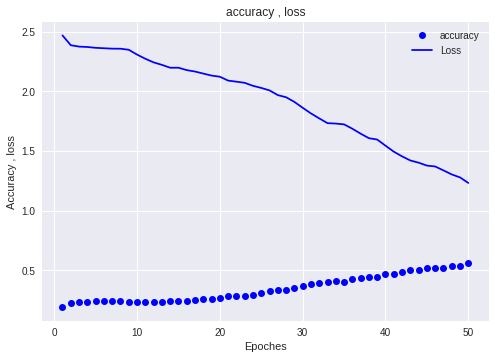

In [13]:
history_dict = history.history
acc_value = history_dict['acc']
loss_value = history_dict['loss']
epoches = range(1,len(loss_value) + 1)

plt.plot(epoches, acc_value, 'bo', label='accuracy')
plt.plot(epoches, loss_value, 'b', label='Loss')
plt.title('accuracy , loss')
plt.xlabel('Epoches')
plt.ylabel('Accuracy , loss')
plt.legend()
plt.show()

In [14]:
!pip install dropbox

import dropbox
from dropbox.files import WriteMode
 
filepath = 'ConvLSTM2D_Riverraid.h5'
access_token = 'PqHDQ2OWJuYAAAAAAAAAWLZTlsb3kgWEhjrKQLeztfPalb3D9eJDueslYKgMNW7d'
dbx = dropbox.Dropbox(access_token)
f = open(filepath, 'rb')
_File = '/' + filepath
dbx.files_upload(f.read(), _File, mode=WriteMode('add'))

    100% |████████████████████████████████| 501kB 7.9MB/s 


FileMetadata(name='ConvLSTM2D_Riverraid.h5', id='id:6ctph7CzaDUAAAAAAAHlfQ', client_modified=datetime.datetime(2018, 10, 31, 20, 14, 50), server_modified=datetime.datetime(2018, 10, 31, 20, 14, 50), rev='48b0aeb94f6', size=41353440, path_lower='/convlstm2d_riverraid.h5', path_display='/ConvLSTM2D_Riverraid.h5', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='4503180cc483065ed22d3e4ff573d2ddd96cbf9ede99eab5f759add96c17d75a')